# Imports , Loading and Preprocessing!


In [1]:
%tensorflow_version 1.x
import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import VGG16,Xception 
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import pickle
import numpy as np
import pandas as pd
import cv2
import os
import seaborn as sb

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
np.random.seed(123)

In [0]:
path_1='/content/drive/My Drive/Dataset/XRAYS'
path_2='/content/drive/My Drive/Dataset/not Covid'
image=[]
labels=[]

In [3]:
print("[INFO] Loading images...\n")
for img in tqdm(os.listdir(path_1)):
  path19=os.path.join(path_1,img)
  data=cv2.imread(path19,0)
  data = cv2.cvtColor(data,cv2.COLOR_BGR2RGB)
  data = cv2.resize(data,(224,224))
  image.append(data)
  labels.append(1)
  

  1%|          | 1/89 [00:00<00:12,  7.16it/s]

[INFO] Loading images...



100%|██████████| 89/89 [00:02<00:00, 35.38it/s]


In [4]:
print("[INFO] Loading images...\n")
for img in tqdm(os.listdir(path_2)):
  path=os.path.join(path_2,img)
  data=cv2.imread(path,0)
  data = cv2.cvtColor(data,cv2.COLOR_BGR2RGB)
  data = cv2.resize(data,(224,224))
  image.append(data)
  labels.append(0)
  

  6%|▌         | 5/90 [00:00<00:01, 43.19it/s]

[INFO] Loading images...



100%|██████████| 90/90 [00:01<00:00, 49.62it/s]


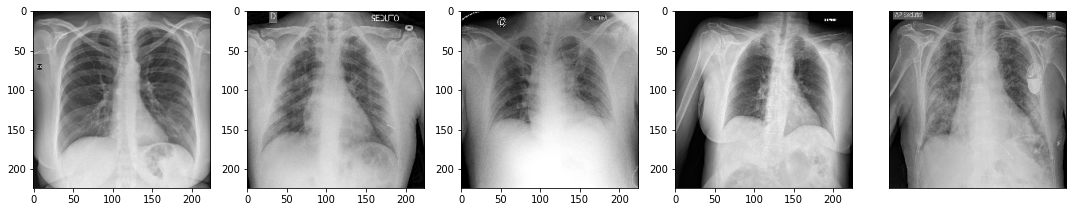

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

plotImages(image)

In [0]:
images_vgg=image.copy()
images_xception=image.copy()

In [0]:
labels=np.array(labels)
images_vgg=np.array(images_vgg)/255

In [0]:
EPOCHS = 100
BS =32

In [0]:
labelBinariser=LabelBinarizer()
labels = labelBinariser.fit_transform(labels)
labels =keras.utils.to_categorical(labels)
#print(labels)

In [0]:
x_train,x_test,y_train,y_test=train_test_split(images_vgg,labels,random_state=42,stratify=labels,shuffle=True)

# VGG16


In [0]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))


In [0]:

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel=Dense(98,activation='relu')(headModel)
headModel = Dense(2, activation="softmax")(headModel)





model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False


In [0]:
#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer='Adam',
	metrics=["accuracy"])

In [87]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

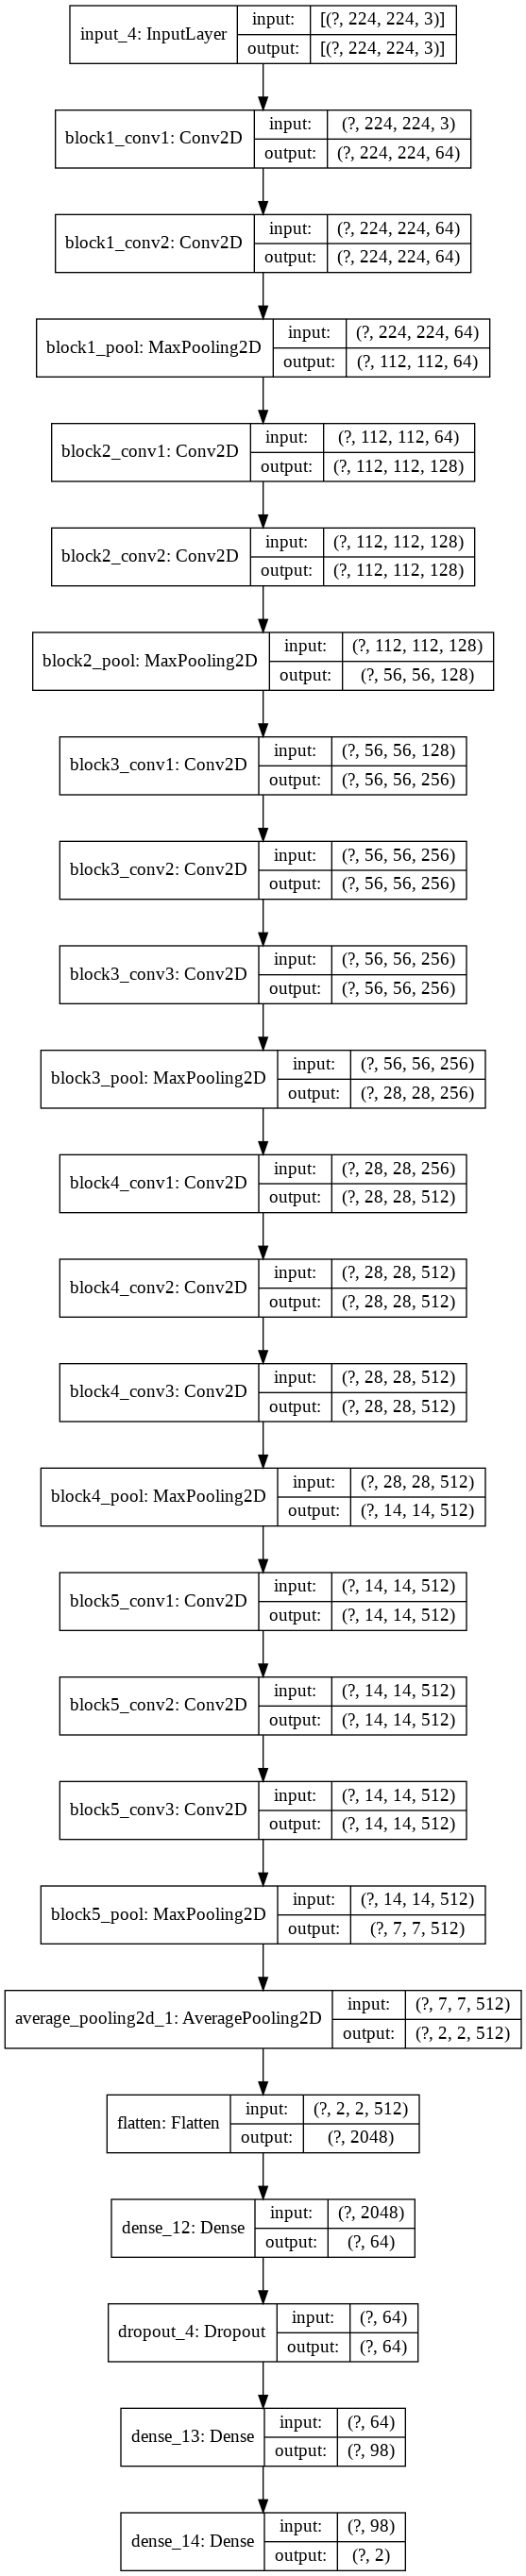

In [88]:
plot_model(model,to_file='vgg16.png',show_shapes=True,show_layer_names=True)

In [0]:
ImageAug=ImageDataGenerator(rotation_range=25,fill_mode='nearest',zoom_range=0.5,vertical_flip=True)

In [0]:
filepath='best_model_vgg16.pkl'
checkpoint=EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='min',restore_best_weights=True)
checkpoint2=ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1,save_best_only=True)
my_model=[checkpoint,checkpoint2]

In [92]:

H= model.fit_generator(
	ImageAug.flow(x_train, y_train, batch_size=BS),
	steps_per_epoch=16,
	validation_data=(x_test, y_test),
	validation_steps=32,
	epochs=EPOCHS,
	callbacks=my_model,
	verbose=0,shuffle=True)


Epoch 00001: val_loss improved from inf to 0.37605, saving model to best_model_vgg16.pkl

Epoch 00002: val_loss improved from 0.37605 to 0.27195, saving model to best_model_vgg16.pkl

Epoch 00003: val_loss improved from 0.27195 to 0.21183, saving model to best_model_vgg16.pkl

Epoch 00004: val_loss improved from 0.21183 to 0.19434, saving model to best_model_vgg16.pkl

Epoch 00005: val_loss did not improve from 0.19434

Epoch 00006: val_loss improved from 0.19434 to 0.16212, saving model to best_model_vgg16.pkl

Epoch 00007: val_loss did not improve from 0.16212

Epoch 00008: val_loss improved from 0.16212 to 0.14575, saving model to best_model_vgg16.pkl

Epoch 00009: val_loss did not improve from 0.14575

Epoch 00010: val_loss improved from 0.14575 to 0.12329, saving model to best_model_vgg16.pkl

Epoch 00011: val_loss did not improve from 0.12329

Epoch 00012: val_loss did not improve from 0.12329

Epoch 00013: val_loss improved from 0.12329 to 0.08048, saving model to best_model_vg

In [0]:
model.save('vgg16')

In [94]:
print("[INFO] evaluating network...")
predicted = model.predict(x_test, batch_size=BS)

# label with corresponding largest predicted probability
predicted = np.argmax(predicted, axis=1)

# Formatted classification report
print(classification_report(y_test.argmax(axis=1), predicted))


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.95      0.95      0.95        22

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



acc: 0.96
sensitivity: 0.96
specificity: 0.95


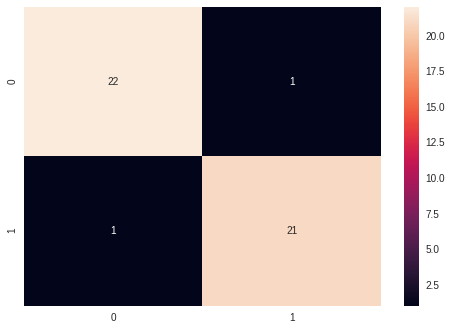

In [95]:
cm = confusion_matrix(y_test.argmax(axis=1), predicted)
total = sum(sum(cm))
acc_vgg = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.2f}".format(acc_vgg))
print("sensitivity: {:.2f}".format(sensitivity))
print("specificity: {:.2f}".format(specificity))
sb.heatmap(cm,annot=True)
plt.show()

In [0]:
history=H.history
history=pd.DataFrame(history)
rows,cols=history.shape

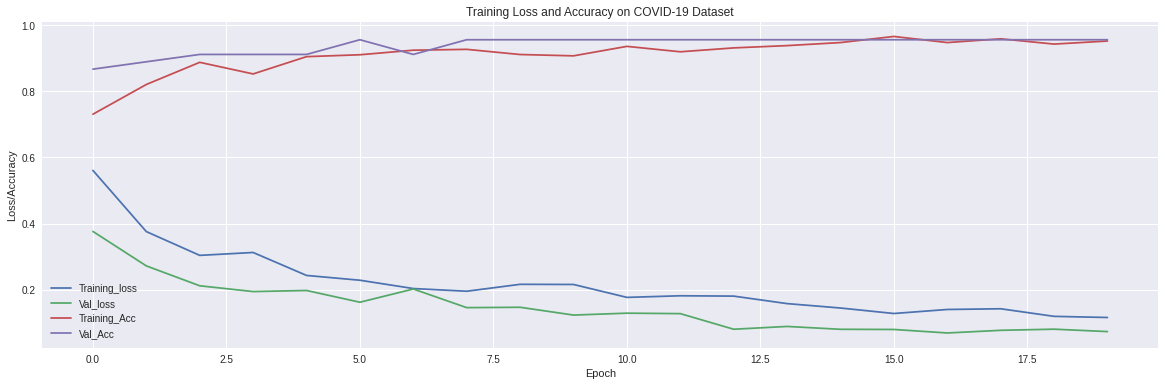

In [97]:
plt.style.use('seaborn')
plt.figure(figsize=(20,6))
sb.lineplot(np.arange(0, rows), history['loss'],label='Training_loss')
sb.lineplot(np.arange(0, rows), history["val_loss"],label='Val_loss')
sb.lineplot(np.arange(0, rows), history["acc"],label='Training_Acc')
sb.lineplot(np.arange(0, rows), history["val_acc"],label='Val_Acc')
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.show()

# XCEPTION

In [0]:
modelX=Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [0]:
headModelX = modelX.output
#headModelX = AveragePooling2D(pool_size=(3, 3))(headModelX)
headModelX = Flatten(name="flatten")(headModelX)
headModelX = Dense(8,activation='relu')(headModelX)
headModelX = Dropout(0.5)(headModelX)
headModelX=Dense(512,activation='relu')(headModelX)
headModelX = Dense(2, activation="softmax")(headModelX)



modelXc = Model(inputs=modelX.input, outputs=headModelX)
for layer in modelXc.layers:
	layer.trainable = False

In [0]:
opt=Adam(learning_rate=1e-5)
modelXc.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [0]:
filepath='best_model_xception.pkl'
checkpoint=EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='min',restore_best_weights=True)
checkpoint2=ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=2,save_best_only=True)
my_modelX=[checkpoint,checkpoint2]

In [0]:
ImageAug2=ImageDataGenerator(zoom_range=0.5,fill_mode='nearest')

In [0]:
images_xception=np.array(images_xception)/.255

In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(images_vgg,labels,stratify=labels,random_state=42)

In [38]:
H2= modelXc.fit_generator(ImageAug2.flow(x_train, y_train, batch_size=20),
	steps_per_epoch=16,
	validation_data=(x_test, y_test),
	validation_steps=32,
	epochs=80,
	callbacks=my_modelX,
	verbose=0,
  shuffle=True)


Epoch 00001: val_loss improved from inf to 0.71343, saving model to best_model_xception.pkl

Epoch 00002: val_loss did not improve from 0.71343

Epoch 00003: val_loss did not improve from 0.71343

Epoch 00004: val_loss did not improve from 0.71343


In [0]:
modelXc = Model(inputs=modelX.input, outputs=headModelX)
for layer in modelXc.layers:
	layer.trainable = True

In [0]:
modelXc.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [41]:
H2 =modelXc.fit_generator(ImageAug2.flow(x_train, y_train),
	steps_per_epoch=16,
	validation_data=(x_test,y_test),
	validation_steps=32,
	epochs=20,
	shuffle=True)

Epoch 1/20
16/16 [==============================] - 22s 1s/step - loss: 0.6916 - acc: 0.5242 - val_loss: 0.6890 - val_acc: 0.6000
Epoch 2/20
16/16 [==============================] - 11s 689ms/step - loss: 0.6619 - acc: 0.6667 - val_loss: 0.6617 - val_acc: 0.5111
Epoch 3/20
16/16 [==============================] - 12s 771ms/step - loss: 0.6125 - acc: 0.6826 - val_loss: 0.5902 - val_acc: 0.6222
Epoch 4/20
16/16 [==============================] - 11s 700ms/step - loss: 0.5602 - acc: 0.7475 - val_loss: 0.5296 - val_acc: 0.7556
Epoch 5/20
16/16 [==============================] - 12s 730ms/step - loss: 0.4919 - acc: 0.7880 - val_loss: 0.5151 - val_acc: 0.6222
Epoch 6/20
16/16 [==============================] - 11s 709ms/step - loss: 0.4848 - acc: 0.7672 - val_loss: 0.4638 - val_acc: 0.7556
Epoch 7/20
16/16 [==============================] - 12s 774ms/step - loss: 0.4193 - acc: 0.8565 - val_loss: 0.3994 - val_acc: 0.8889
Epoch 8/20
16/16 [==============================] - 12s 739ms/step - los

In [42]:
print("[INFO] evaluating network...")
predictedX = modelXc.predict(x_test, batch_size=BS)

# label with corresponding largest predicted probability
predictedX = np.argmax(predictedX, axis=1)

# Formatted classification report
xception_rep=classification_report(y_test.argmax(axis=1), predictedX)
print(xception_rep)


[INFO] evaluating network...
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       0.96      1.00      0.98        22

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



acc: 0.98
sensitivity: 0.96
specificity: 1.00


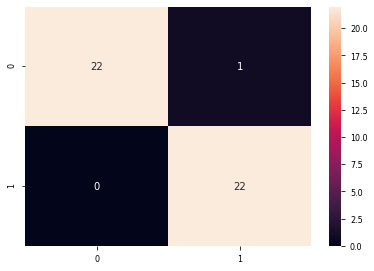

In [43]:
cm = confusion_matrix(y_test.argmax(axis=1), predictedX)
total = sum(sum(cm))
acc_x = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.2f}".format(acc_x))
print("sensitivity: {:.2f}".format(sensitivity))
print("specificity: {:.2f}".format(specificity))
sb.heatmap(cm,annot=True)
plt.show()

In [0]:
historyX=H2.history
historyX=pd.DataFrame(historyX)
rows,cols=historyX.shape

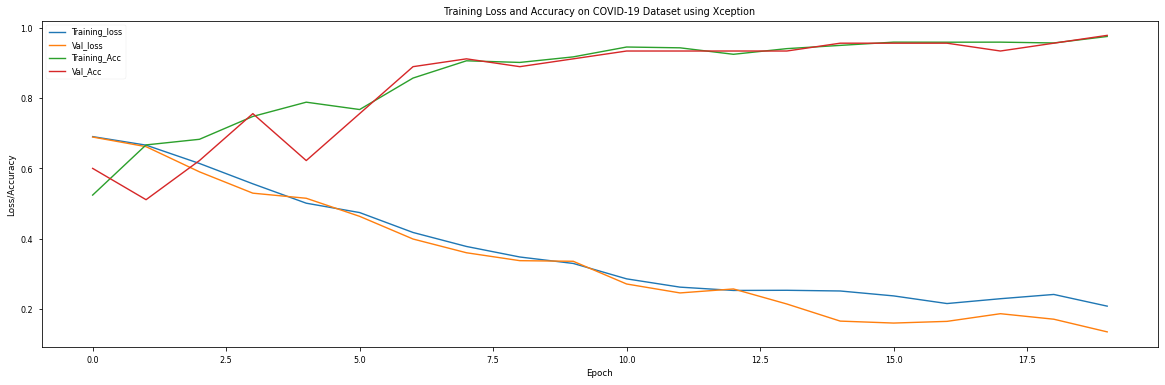

In [45]:
plt.style.use('seaborn-paper')
plt.figure(figsize=(20,6))
sb.lineplot(np.arange(0, rows), historyX['loss'],label='Training_loss')
sb.lineplot(np.arange(0, rows), historyX["val_loss"],label='Val_loss')
sb.lineplot(np.arange(0, rows), historyX["acc"],label='Training_Acc')
sb.lineplot(np.arange(0, rows), historyX["val_acc"],label='Val_Acc')
plt.title("Training Loss and Accuracy on COVID-19 Dataset using Xception")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.show()

In [46]:
H2.history['acc']

[0.5241935,
 0.6666667,
 0.6826087,
 0.747549,
 0.7880184,
 0.76715684,
 0.8565217,
 0.90553,
 0.90092164,
 0.9166667,
 0.9447005,
 0.94239634,
 0.92401963,
 0.94009215,
 0.94930875,
 0.95852536,
 0.9583333,
 0.95852536,
 0.9562212,
 0.9746544]

# SUPPORT VECTOR MACHINE

In [0]:
image_svm=[]
lb=[]

In [55]:
for name in tqdm(os.listdir(path_1)):
  path_svm1=os.path.join(path_1,name)
  data=cv2.imread(path_svm1,0)
  data=cv2.resize(data,(180,180),interpolation=cv2.INTER_CUBIC)
  image_svm.append(data)
  lb.append(1)


100%|██████████| 89/89 [00:02<00:00, 37.99it/s]


In [56]:
for name in tqdm(os.listdir(path_2)):
  path_svm2=os.path.join(path_2,name)
  data=cv2.imread(path_svm2,0)
  data=cv2.resize(data,(180,180),interpolation=cv2.INTER_CUBIC)
  image_svm.append(data)
  lb.append(0)

100%|██████████| 90/90 [00:01<00:00, 56.97it/s]


In [57]:
image_svm=np.array(image_svm)/.255
image_svm=image_svm.reshape((len(image_svm),-1))
lb=np.array(lb)
lb.shape

(179,)

In [0]:
train_x,test_x,train_y,test_y=train_test_split(image_svm,lb,stratify=lb,shuffle=True,random_state=56)

In [0]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear','sigmoid']}  
  
grid=GridSearchCV(estimator=SVC,param_grid=param_grid,refit=True,verbose=0)
grid.fit(train_x,train_y)
print(grid.best_params_) 
print(grid.best_estimator_) 

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [59]:

SVC=svm.SVC(C=0.1,gamma=1,kernel='linear')
SVC.fit(train_x,train_y)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
svm_pred=SVC.predict(test_x)
svm_rep=classification_report(test_y, svm_pred)
print(svm_rep)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.92      1.00      0.96        22

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



In [0]:
cm_svm=confusion_matrix(test_y,svm_pred)
total=sum(sum(cm_svm))
accuracy_svm=(cm_svm[0, 0] + cm_svm[1, 1]) / total

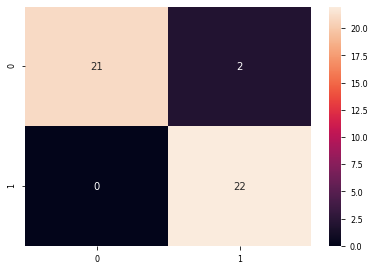

In [62]:
sb.heatmap(cm_svm,annot=True)

In [0]:
filename="svm_corona.sav"
pickle.dump(SVC,open(filename,'wb'))
algo=['VGG16','XCEPTION','SVM']

In [0]:
PERFORMANCE=pd.DataFrame()
PERFORMANCE['ALGORITHM']=algo
PERFORMANCE['ACCURACY']=[max(H.history['acc']),max(historyX['acc']),accuracy_svm]
#ERFORMANCE['SVM']=accuracy

In [100]:
PERFORMANCE

,ALGORITHM,ACCURACY
0,VGG16,0.965438
1,XCEPTION,0.974654
2,SVM,0.955556


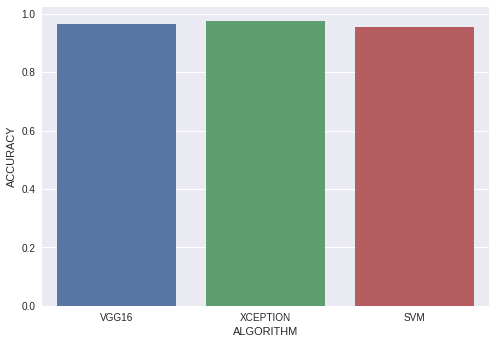

In [101]:
plt.subplot(111)
sb.barplot(x=PERFORMANCE['ALGORITHM'],y=PERFORMANCE['ACCURACY'])
plt.show()
#plt.xticks([])


In [0]:
#results=pd.DataFrame()
#results['Actual']=y_test.argmax(axis=1)
#results['Vgg16_Pred']=predicted
#results['Xception_Pred']=predictedX
#results['Actual_SVM']=test_y
#results['SVM_Pred']=svm_pred
#results.to_csv("results.csv")

In [0]:
results

,Actual,Vgg16_Pred,Xception_Pred,Actual_SVM,SVM_Pred
0,1,1,1,0,0
1,0,0,0,0,0
2,0,0,0,1,1
3,1,1,1,0,0
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,0,0
7,1,1,1,0,0
8,1,1,1,0,0
9,0,0,0,1,1


In [0]:
plot_model(modelX,to_file='xception.png',show_shapes=True,show_layer_names=True)